# Cross-Image Exemplar Search Test

**Goal**: Take one bbox from D8_1.png as exemplar, find same objects in D8_2, D8_3, D8_4

In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

# Add sam3 to path
sys.path.insert(0, "D:/SAM/sam3")

# Enable bfloat16
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
print("Ready!")

Ready!


## 1. Load Model

In [2]:
from sam3 import build_sam3_image_model
from sam3.cross_image_exemplar import CrossImageExemplarSearch

bpe_path = "d:/miniconda3/Lib/site-packages/sam3/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)
print("Model loaded!")

D:\SAM/sam3\sam3\model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
d:\miniconda3\Lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)


Model loaded!


## 2. Create Cross-Image Searcher

In [3]:
searcher = CrossImageExemplarSearch(model, device="cuda")
print("Searcher ready!")

Searcher ready!


## 3. Set Reference Exemplar

Using D8_1.png and one of the detected bboxes as exemplar

In [4]:
# Reference image and bbox
REFERENCE = "D:/SAM/samples/Encoding_test/D8_1.png"

# Your detected bboxes from D8_1 (pick one as exemplar)
ALL_BBOXES = [
    [1252.8608, 515.0477, 1296.5815, 559.2898],
    [1253.2261, 1092.1775, 1295.8339, 1136.0105],
    [1253.4272, 825.3398, 1295.8400, 869.3641],
    [27.9943, 515.2542, 71.4246, 558.5508],
    [43.0578, 57.7218, 85.8391, 100.2834],
]

# Use first bbox as exemplar
EXEMPLAR_BBOX = ALL_BBOXES[1]
print(f"Using bbox: {EXEMPLAR_BBOX}")

Using bbox: [1253.2261, 1092.1775, 1295.8339, 1136.0105]


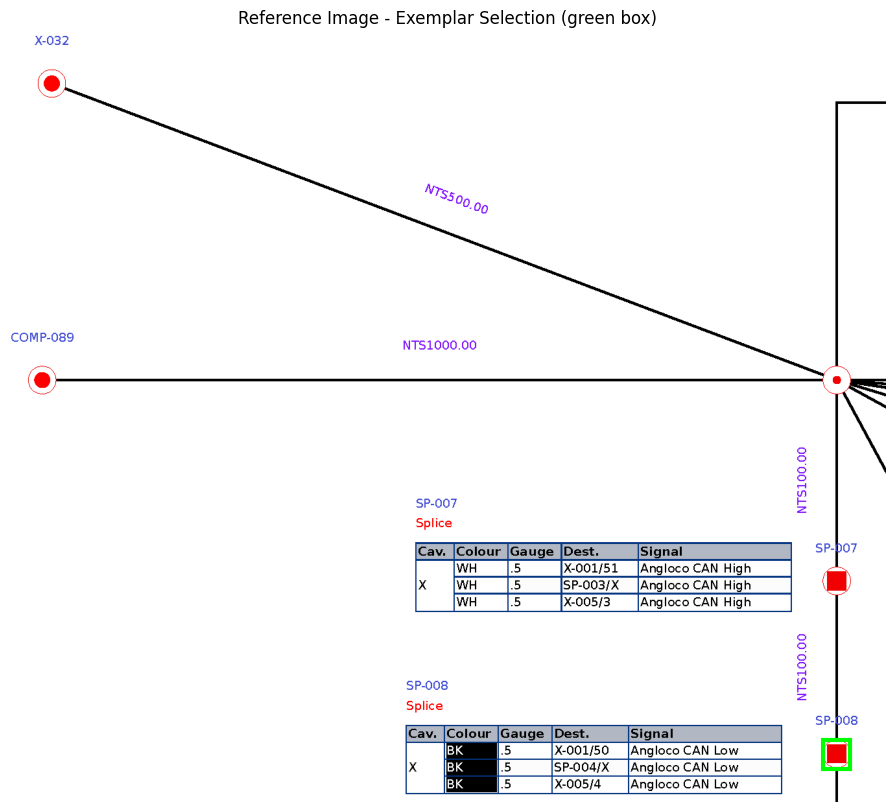

In [5]:
# Show reference image with exemplar bbox
ref_image = Image.open(REFERENCE).convert("RGB")

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(ref_image)

x1, y1, x2, y2 = EXEMPLAR_BBOX
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='lime', facecolor='none')
ax.add_patch(rect)
ax.set_title("Reference Image - Exemplar Selection (green box)")
ax.axis('off')
plt.show()

In [6]:
# Extract exemplar tokens from reference
searcher.set_reference(
    reference_image=ref_image,
    bbox=EXEMPLAR_BBOX,
    label=1,  # positive exemplar
    bbox_format="xyxy",
)
print("Exemplar tokens extracted and cached!")
print(f"Token shape: {searcher.exemplar_tokens.tokens.shape}")

TypeError: CrossImageExemplarSearch.set_reference() got an unexpected keyword argument 'reference_image'

## 4. Search in Target Images

In [ ]:
# Target images
TARGETS = [
    "D:/SAM/samples/Encoding_test/D8_2.png",
    "D:/SAM/samples/Encoding_test/D8_3.png",
    "D:/SAM/samples/Encoding_test/D8_4.png",
]

THRESHOLD = 0.6

In [ ]:
def show_results(image, result, title):
    """Show image with detected boxes."""
    # Convert bfloat16 to float32 before numpy (required for bfloat16 mode)
    boxes = result.boxes.float().cpu().numpy()
    scores = result.scores.float().cpu().numpy()
    
    # Boxes are already in pixel coordinates (scaled to original size)
    # No need to denormalize
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(image)
    
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'{score:.2f}', color='white', fontsize=10,
                bbox=dict(facecolor='green', alpha=0.7))
    
    ax.set_title(f"{title} - {len(boxes)} detections (presence: {result.presence_score:.2f})")
    ax.axis('off')
    plt.show()
    
    return boxes, scores

In [ ]:
# Process D8_2
target = Image.open(TARGETS[0]).convert("RGB")
result = searcher.segment(target, threshold=THRESHOLD)
show_results(target, result, "D8_2")

In [ ]:
# Process D8_3
target = Image.open(TARGETS[1]).convert("RGB")
result = searcher.segment(target, threshold=THRESHOLD)
show_results(target, result, "D8_3")

In [ ]:
# Process D8_4
target = Image.open(TARGETS[2]).convert("RGB")
result = searcher.segment(target, threshold=THRESHOLD)
show_results(target, result, "D8_4")

## 5. Try Different Exemplar

You can change which bbox is used as exemplar

In [ ]:
# Try a different exemplar bbox
NEW_EXEMPLAR = ALL_BBOXES[1]  # Change index 0-4 to try different exemplars

searcher.set_reference(
    reference_image=ref_image,
    bbox=NEW_EXEMPLAR,
    label=1,
    bbox_format="xyxy",
)
print(f"New exemplar: {NEW_EXEMPLAR}")

In [ ]:
# Test with new exemplar
target = Image.open(TARGETS[0]).convert("RGB")
result = searcher.segment(target, threshold=THRESHOLD)
show_results(target, result, "D8_2 (new exemplar)")

## 6. Multiple Exemplars (Optional)

Add multiple exemplars for better robustness

In [ ]:
# Reset and add multiple exemplars
searcher.set_reference(ref_image, ALL_BBOXES[0], label=1, bbox_format="xyxy")
searcher.add_exemplar(ref_image, ALL_BBOXES[1], label=1, bbox_format="xyxy")
searcher.add_exemplar(ref_image, ALL_BBOXES[2], label=1, bbox_format="xyxy")

print(f"Using {3} exemplars")
print(f"Combined token shape: {searcher.exemplar_tokens.tokens.shape}")

In [ ]:
# Test with multiple exemplars
target = Image.open(TARGETS[0]).convert("RGB")
result = searcher.segment(target, threshold=THRESHOLD)
show_results(target, result, "D8_2 (3 exemplars)")